# Similarity-Based Constraint Score For Feature Selection Notebook

In this notebook, you will find a comprehensive summary of the project, detailing key steps undertaken and presenting results obtained during the implementation of our innovative constraint score.



## Part 1: Contraint score 4
Firstly we would like to implement the contraints score 4: $ \begin{equation}
SC^4_r = \frac{\tilde{f_r}^TL\tilde{f_r}}{\tilde{f_r}^TD\tilde{f_r}}*\frac{{f_r}^TL^\mathcal{M}f_r}{{f_r}^TL^\mathcal{C}f_r} = SL_r*SC_r
\end{equation} $
And see if our results correspond to the outcomes in the thesis by Maryam Kalakesh on the wine dataset.

In [30]:
%cd /Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS
import numpy as np
import pandas as pd
import sklearn.datasets as skd
from sklearn.preprocessing import StandardScaler
from c_scores import *
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as Knn
import matplotlib.pyplot as plt

/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS


/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [31]:
# Loding the wine data
X = skd.load_wine()
X_wine = X.data
X_target = X.target[np.newaxis].T

### To reproduce the experiments in the same conditions we need to partition the data and normalize them :
178 samples characterized by 13 features (n=178, d=13). These samples are divided into 3 classes with 59, 71, and 48 instances respectively. We select 30, 36, and 24 instances from each class to constitute the training set. And generating 10 constraints


In [32]:
wine_db = np.concatenate((X_wine,X_target), axis=1)
np.random.shuffle(wine_db)
target = wine_db[:,-1]
data = wine_db[:,:-1]
X_class_1 = target == 0
X_class_2 = target == 1
X_class_3 = target == 2
# now we need 30 prototypes for the first class 36 for the second and 24 for the third
X_class_1 = data[X_class_1]
X_class_2 = data[X_class_2]
X_class_3 = data[X_class_3]

X_class_1 = X_class_1[:30]
X_class_2 = X_class_2[:36]
X_class_3 = X_class_3[:24]

X_data_train_2 = np.concatenate((X_class_1,X_class_2,X_class_3), axis=0)
X_target_train_2 = np.concatenate((np.zeros(30),np.ones(36),np.ones(24)*2), axis=0)[np.newaxis].T
# now we need to drop the prototypes from the data
X_data_test_2 = np.delete(data, np.concatenate((np.arange(30),np.arange(59,95),np.arange(131,155))), axis=0)
X_target_test_2 = np.delete(target, np.concatenate((np.arange(30),np.arange(59,95),np.arange(131,155))), axis=0)
X_data_train_2_labels = np.concatenate(((X_data_train_2,X_target_train_2,)), axis=1)
#now we have our training and test data

In [33]:
# We calculate the constraint score 4 for the training data with 3 labels available for each class
X_data_train_2_constraints= generate_constraints(X_data_train_2_labels,3)
constraint_score_4 = laplacian_score(X_data_train_2)*constraint_score_1(X_data_train_2_constraints)
features_cs4 = np.argsort(constraint_score_4)
features_ls = np.argsort(laplacian_score(X_data_train_2))
features_cs1 = np.argsort(constraint_score_1(X_data_train_2_constraints))
print(features_cs4,features_ls,features_cs1)

[12  4  0  3 11  5  2  6 10  9  8  1  7] [12  4  3  0  2 11 10  5  9  6  8  7  1] [ 0 12  6  5 11  3  9  4 10  8  2  1  7]


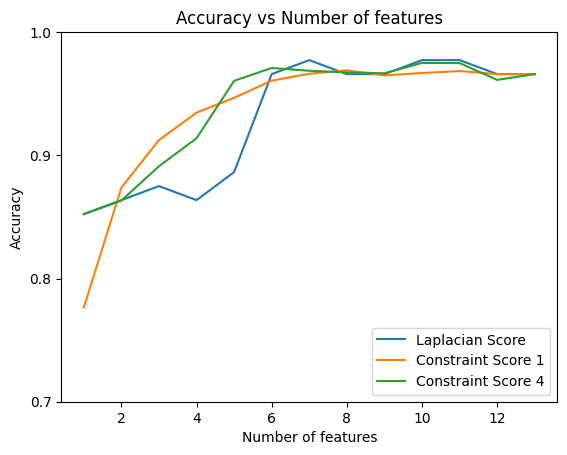

In [34]:
from sklearn.preprocessing import StandardScaler
n = 14
rep = 100
knn = Knn(n_neighbors=1)
all_accuracy_cs4 = np.zeros((rep,n-1))
all_accuracy_ls = np.zeros((rep,n-1))
all_accuracy_cs1 = np.zeros((rep,n-1))
for j in range(rep):
    X_data_train_2_labels = np.concatenate(((X_data_train_2,X_target_train_2,)), axis=1)
    X_data_train_2_constraints = generate_constraints(X_data_train_2_labels,3 )
    constraint_score_4 = laplacian_score(X_data_train_2)*constraint_score_1(X_data_train_2_constraints)
    features_cs4 = np.argsort(constraint_score_4)
    features_ls = np.argsort(laplacian_score(X_data_train_2))
    features_cs1 = np.argsort(constraint_score_1(X_data_train_2_constraints))
    Accuracy_cs4 = np.zeros(n-1)
    Accuracy_ls = np.zeros(n-1)
    Accuracy_cs1 = np.zeros(n-1)
    for i in range(1,n):
        X_wine_train_cs4 = np.delete(X_data_train_2, features_cs4[i:], axis=1)
        X_wine_test_cs4 = np.delete(X_data_test_2, features_cs4[i:], axis=1)
        y_train = X_target_train_2.ravel()
        y_test = X_target_test_2
        scaler = StandardScaler()
        scaler.fit(X_wine_train_cs4)
        X_wine_train_cs4 = scaler.transform(X_wine_train_cs4)
        X_wine_test_cs4 = scaler.transform(X_wine_test_cs4)
        knn.fit(X_wine_train_cs4, y_train)
        y_pred = knn.predict(X_wine_test_cs4)
        Accuracy_cs4[i-1] = np.mean(y_pred == y_test)

        X_wine_train_ls = np.delete(X_data_train_2, features_ls[i:], axis=1)
        X_wine_test_ls = np.delete(X_data_test_2, features_ls[i:], axis=1)
        scaler = StandardScaler()
        scaler.fit(X_wine_train_ls)
        X_wine_train_ls = scaler.transform(X_wine_train_ls)
        X_wine_test_ls = scaler.transform(X_wine_test_ls)
        knn.fit(X_wine_train_ls, y_train)
        y_pred = knn.predict(X_wine_test_ls)
        Accuracy_ls[i-1] = np.mean(y_pred == y_test)

        X_wine_train_cs1 = np.delete(X_data_train_2, features_cs1[i:], axis=1)
        X_wine_test_cs1 = np.delete(X_data_test_2, features_cs1[i:], axis=1)
        scaler = StandardScaler()
        scaler.fit(X_wine_train_cs1)
        X_wine_train_cs1 = scaler.transform(X_wine_train_cs1)
        X_wine_test_cs1 = scaler.transform(X_wine_test_cs1)
        knn.fit(X_wine_train_cs1, y_train)
        y_pred = knn.predict(X_wine_test_cs1)
        Accuracy_cs1[i-1] = np.mean(y_pred == y_test)
    all_accuracy_cs4[j,:] = Accuracy_cs4
    all_accuracy_ls[j,:] = Accuracy_ls
    all_accuracy_cs1[j,:] = Accuracy_cs1
plt.plot(range(1,n), np.mean(all_accuracy_ls, axis=0))
plt.plot(range(1,n), np.mean(all_accuracy_cs1, axis=0))
plt.plot(range(1,n), np.mean(all_accuracy_cs4, axis=0))
plt.legend(['Laplacian Score', 'Constraint Score 1', 'Constraint Score 4'], loc='lower right')
plt.xlabel('Number of features')
new_y_ticks = np.arange(0.7, 1, 0.1)
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of features')
plt.yticks(new_y_ticks)
plt.show()

In [62]:
def score_supervised(X):
    labels = X[:,-1][np.newaxis].T
    X = X[:,:-1]
    must_link, cannot_link = get_constraints(labels)
    similarity_matrix = rbf_kernel(X)
    similarity_matrix_supervised = np.zeros((len(labels), len(labels)))
    for j in range(len(labels)):
        for k in range(len(labels)):
            if must_link[j, k] == 1:
                similarity_matrix_supervised[j, k] = 1
            if cannot_link[j, k] == 1:
                similarity_matrix_supervised[j, k] = 0
            else:
                similarity_matrix_supervised[j, k] = similarity_matrix[j, k]
    score = np.linalg.norm(similarity_matrix_supervised - similarity_matrix)
    return score

score_supervised(wine_db)

0.2965762657612139

In [53]:
def nearest_prototype(x, prototypes):
    distance = np.zeros(len(prototypes))
    for i in range(len(prototypes)):
        distance[i] = np.linalg.norm(x - prototypes[i])
    return np.argmin(distance)

In [64]:
def score_semi_supervised(X):
    labels = X[:,-1][np.newaxis].T
    mask = ~np.isnan(labels)
    mask = np.squeeze(mask)  # Ensure the boolean array is 1D
    prototypes = X[mask, :]
    labels_prototypes = prototypes[:,-1][np.newaxis].T
    must_link = get_constraints(labels)[0]
    prototypes = prototypes[:,:-1] # we remove the labels from the prototypes
    X = X[:,:-1] # we remove the labels from the data
    similarity_matrix = rbf_kernel(X) #The true similarity matrix
    similarity_matrix_semi_supervised = np.zeros((len(X), len(X))) #The constructed similarity matrix with constraints
    for i in range(len(X)):
        NP_Xi = nearest_prototype(X[i], prototypes)
        for j in range(len(X)):
            NP_Xj = nearest_prototype(X[j], prototypes)
            if labels_prototypes[NP_Xi] == labels_prototypes[NP_Xj] or must_link[i, j] == 1:
                similarity_matrix_semi_supervised[i, j] = 1
            else:
                similarity_matrix_semi_supervised[i, j] = 0
    score = np.linalg.norm(similarity_matrix_semi_supervised - similarity_matrix)
    return score


score_semi_supervised(wine_db)


103.09112090916932

In [66]:
def similarity_constraint_score(X,score,m):
    target = X[:, -1][np.newaxis].T
    X = X[:, :-1]
    n = X.shape[1]
    # Center and normalize the data
    scaler = StandardScaler()
    scaler.fit_transform(X)
    selected_features = []
    for j in range(m):
        similarity_matrix_score =[]
        if j == 0:
            for i in range(n):
                similarity_matrix_score.append(score(np.concatenate((X[:,i][np.newaxis].T,target), axis=1)))
            feature_rank = np.argsort(similarity_matrix_score)
            selected_features.append(feature_rank[0])
            features = np.delete(X, feature_rank[1:], axis=1)
        else :
            for i in range(n):
                if i not in selected_features:
                    fi = np.concatenate((features,X[:,i][np.newaxis].T), axis=1)
                    fi = np.concatenate((fi,target), axis=1)
                    similarity_matrix_score.append(score(fi))
                else:
                    similarity_matrix_score.append(np.inf)
            feature_rank = np.argsort(similarity_matrix_score)
            selected_features.append(feature_rank[0])
            features = np.concatenate((features,X[:,feature_rank[0]][np.newaxis].T), axis=1)
    return (selected_features)







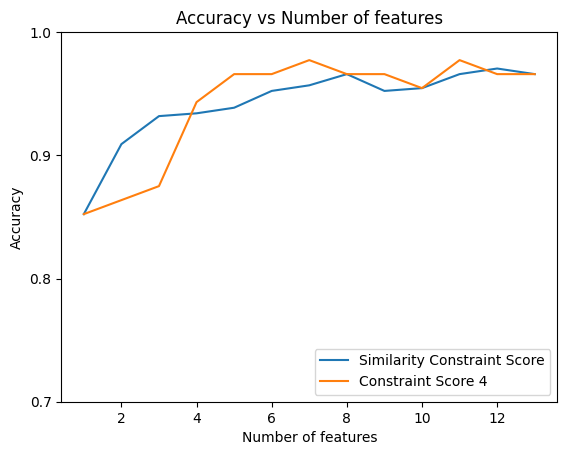

In [68]:
n = 14
rep = 5
knn = Knn(n_neighbors=1)
all_accuracy_fs = np.zeros((rep,n-1))
all_accuracy_cs4 = np.zeros((rep,n-1))
for j in range(rep):
    X_data_train_2_labels = np.concatenate(((X_data_train_2,X_target_train_2,)), axis=1)
    X_data_train_2_constraints = generate_constraints(X_data_train_2_labels,3 )
    features_fs = similarity_constraint_score(X_data_train_2_constraints,score_semi_supervised,n-1)
    features_cs4 = np.argsort(constraint_score_4)
    Accuracy_fs = np.zeros(n-1)
    Accuracy_cs4 = np.zeros(n-1)
    for i in range(1,n):
        X_wine_train_fs = np.delete(X_data_train_2, features_fs[i:], axis=1)
        X_wine_test_fs = np.delete(X_data_test_2, features_fs[i:], axis=1)
        y_train = X_target_train_2.ravel()
        y_test = X_target_test_2
        scaler = StandardScaler()
        scaler.fit(X_wine_train_fs)
        X_wine_train_fs = scaler.transform(X_wine_train_fs)
        X_wine_test_fs = scaler.transform(X_wine_test_fs)
        knn.fit(X_wine_train_fs, y_train)
        y_pred = knn.predict(X_wine_test_fs)
        Accuracy_fs[i-1] = np.mean(y_pred == y_test)

        X_wine_train_cs4 = np.delete(X_data_train_2, features_cs4[i:], axis=1)
        X_wine_test_cs4 = np.delete(X_data_test_2, features_cs4[i:], axis=1)
        scaler = StandardScaler()
        scaler.fit(X_wine_train_cs4)
        X_wine_train_cs4 = scaler.transform(X_wine_train_cs4)
        X_wine_test_cs4 = scaler.transform(X_wine_test_cs4)
        knn.fit(X_wine_train_cs4, y_train)
        y_pred = knn.predict(X_wine_test_cs4)
        Accuracy_cs4[i-1] = np.mean(y_pred == y_test)
    all_accuracy_cs4[j,:] = Accuracy_cs4
    all_accuracy_fs[j,:] = Accuracy_fs

plt.plot(range(1,n), np.mean(all_accuracy_fs, axis=0))
plt.plot(range(1,n), np.mean(all_accuracy_cs4, axis=0))
plt.legend(['Similarity Constraint Score', 'Constraint Score 4'], loc='lower right')
plt.xlabel('Number of features')
new_y_ticks = np.arange(0.7, 1, 0.1)
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of features')
plt.yticks(new_y_ticks)
plt.show()